In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
unconfined=True

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import pandas as pd
import sys
import os
import copy
import tqdm
import itertools
import numpy as np
from itertools import product
from _utils import assign_hydrogen_pdbinfo, map_mol_with_noe

# Distance Calc

In [3]:
def get_distances(noe_mol, bl_mol, omegamc_mol, noe_df):
    mol_atom_names2atom_index, noe_atom_names2mol_atom_names, noe_atom_pair2upper_distance = map_mol_with_noe(noe_mol, noe_df, verbose = False)

    index_1, index_2 = [], [] #symmetric, thus two lists are interchangable
    labels = []
    ref_val = []
    res_dist = [] # distance between residuals
    bond_dist = [] # number of bonds between atoms

    bond_order = Chem.rdmolops.GetDistanceMatrix(noe_mol)

    prev_a = 0 
    prev_b = 0

    for key, val in noe_atom_pair2upper_distance.items():
        tmp_1 = noe_atom_names2mol_atom_names[key[0]]
        tmp_2 = noe_atom_names2mol_atom_names[key[1]]
        #print(key[0])
        #print(tmp_1)
        a = mol_atom_names2atom_index[tmp_1]
        #print(tmp_2[0])
        b = mol_atom_names2atom_index[tmp_2]
    
        if not(b==prev_a and a==prev_b): # ignore reversed pair
            for item in product(a,b):
                #print(item)
                index_1.append(item[0]) # RDKit indexing starts at 0!
                index_2.append(item[1])
                ref_val.append(val)
            
                r1 = int(tmp_1[0]) # string to int conversion
                r2 = int(tmp_2[0])
                if abs(r1 - r2) <= 5: # take the shorter route along the ring, 11 residuals total
                    dist = abs(r1 - r2)
                else:
                    dist = abs(abs(r1 - r2) - 11)
                res_dist.append(dist)
            
                bd = int(bond_order[item[0], item[1]])
                bond_dist.append(bd)
            
                labels.append("{}-{} {}R {}B {}:{}{}-{}:{}{} ({:0.2f})".format(tmp_1[0], tmp_2[0], dist, bd, item[0], tmp_1[0], 
                                                                tmp_1[1], item[1], tmp_2[0], tmp_2[1], val))
    
        prev_a = a
        prev_b = b

    # sort everything for bond_dist (first arg in zip) 
    res_dist, bond_dist, labels, ref_val, index_1, index_2 = (list(t) for t in zip(*sorted(zip(bond_dist, res_dist, labels, ref_val, index_1, index_2))))

    distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(noe_mol, i) for i in tqdm.tqdm(range(noe_mol.GetNumConformers()))])
    noe_dist = distance_matrix_for_each_conformer[:, index_1, index_2]

    distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(bl_mol, i) for i in tqdm.tqdm(range(bl_mol.GetNumConformers()))])
    bl_dist = distance_matrix_for_each_conformer[:, index_1, index_2]
    
    # OMEGA Macrocycle
    distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(omegamc_mol, i) for i in tqdm.tqdm(range(omegamc_mol.GetNumConformers()))])
    omegamc_dist = distance_matrix_for_each_conformer[:, index_1, index_2]
    
    return noe_dist, bl_dist, omegamc_dist, labels, ref_val

In [4]:
ccl4_mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsE/CsE_ccl4_corr_noebounds_numconf5400.pdb", removeHs = False)
dmso_mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsE/CsE_dmso_corr_tol1.25_noebounds_numconf5400.pdb", removeHs = False)
bl_mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsE/CsE_baseline_numconf5400.pdb", removeHs = False)
omegamc_mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsE/Reordered_CsE_OMEGA_MC_numconf232.pdb", removeHs = False)

ccl4_df = pd.read_csv("../CsE/CsE_ccl4_corr_noebounds.csv", sep = "\s", comment = "#")
dmso_df = pd.read_csv("../CsE/CsE_dmso_corr_noebounds.csv", sep = "\s", comment = "#")

ccl4_noe, ccl4_bl, ccl4_omegamc, ccl4_labels, ccl4_ref_val = get_distances(ccl4_mol, bl_mol, omegamc_mol, ccl4_df)
dmso_noe, dmso_bl, dmso_omegamc, dmso_labels, dmso_ref_val = get_distances(dmso_mol, bl_mol, omegamc_mol, dmso_df)

/home/kkajo/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/kkajo/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys
100%|██████████| 232/232 [00:00<00:00, 2001.65it/s]


In [5]:
len(ccl4_labels)

162

In [6]:
ccl4_noe.shape

(5400, 162)

In [7]:
len(ccl4_ref_val)

162

# CCl4

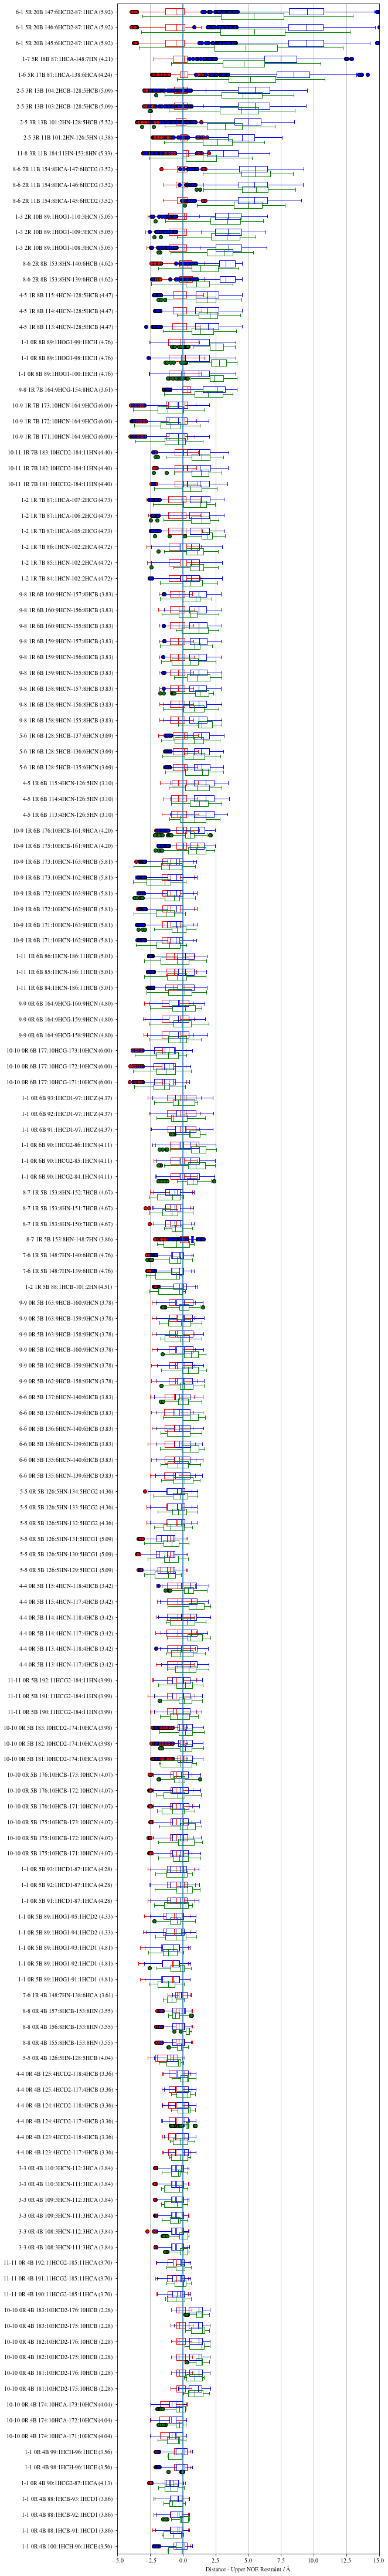

CPU times: user 6.61 s, sys: 287 ms, total: 6.9 s
Wall time: 7.2 s


In [8]:
plot_1 = copy.copy(ccl4_noe) - ccl4_ref_val
plot_2 = copy.copy(ccl4_bl) - ccl4_ref_val
plot_3 = copy.copy(ccl4_omegamc) - ccl4_ref_val

widths = 0.4
offset = 0.3
fig1, ax1 = plt.subplots(1, 1, figsize = (8,80))
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')
green_square = dict(markerfacecolor='g', marker='o')

bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
                   flierprops = red_square, positions = np.array(range(plot_1.shape[1])), manage_ticks=False)
bp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, 
                   flierprops = blue_square, positions = np.array(range(plot_2.shape[1])), manage_ticks=False)
bp_3 = ax1.boxplot([plot_3[:,i] for i in range(plot_3.shape[1])], vert = False, widths = widths, 
                   flierprops = green_square, positions = np.array(range(plot_3.shape[1])) - offset, manage_ticks=False)

set_box_color(bp_1, "red")
set_box_color(bp_2, "blue")
set_box_color(bp_3, "green")
# with the offset it takes much longer to plot
#ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions = np.array(range(plot_1.shape[1])) + offset, vert = False, flierprops = red_square, widths = widths)
#ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], positions = np.array(range(plot_2.shape[1])) - offset, vert = False, flierprops = blue_square, widths = widths)

ax1.set_xlabel('Distance - Upper NOE Restraint / Å')
plt.grid(axis = "x", which = "both")
# plt.grid(axis = "y", which = "major")
# plt.axvline(x=2.20589566)
plt.yticks(range(plot_1.shape[1]), ccl4_labels)
plt.ylim(0 - 0.5, plot_1.shape[1] - 0.5)
plt.xlim(-5, 15)
plt.axvline(x=0)

%time plt.show()

# DMSO - !!! Tolerance = 1.25, Ref_val is nominal !!!

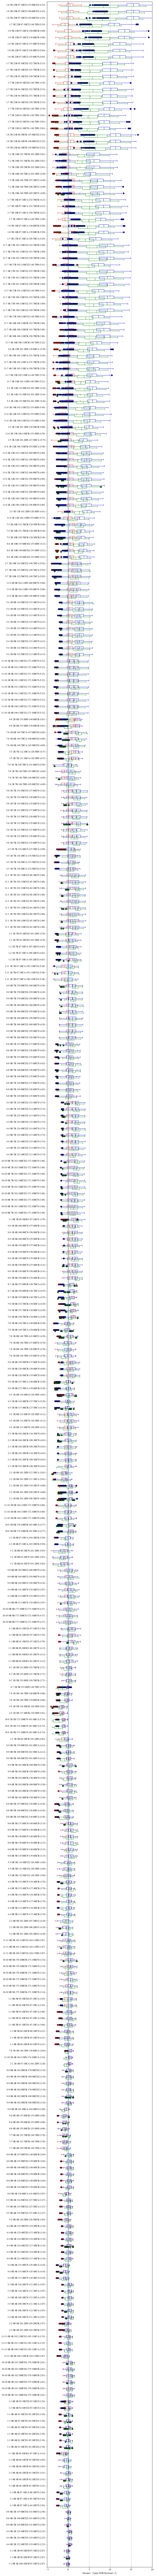

CPU times: user 16.4 s, sys: 424 ms, total: 16.9 s
Wall time: 16.3 s


In [9]:
plot_1 = copy.copy(dmso_noe) - dmso_ref_val
plot_2 = copy.copy(dmso_bl) - dmso_ref_val
plot_3 = copy.copy(dmso_omegamc) - dmso_ref_val

widths = 0.4
offset = 0.2
fig1, ax1 = plt.subplots(1, 1, figsize = (8,200))
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')
green_square = dict(markerfacecolor='g', marker='o')

bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
                   flierprops = red_square, positions = np.array(range(plot_1.shape[1])), manage_ticks=False)
bp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, 
                   flierprops = blue_square, positions = np.array(range(plot_2.shape[1])), manage_ticks=False)
bp_3 = ax1.boxplot([plot_3[:,i] for i in range(plot_3.shape[1])], vert = False, widths = widths, 
                   flierprops = green_square, positions = np.array(range(plot_3.shape[1])) - offset, manage_ticks=False)

set_box_color(bp_1, "red")
set_box_color(bp_2, "blue")
set_box_color(bp_3, "green")
# with the offset it takes much longer to plot
#ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions = np.array(range(plot_1.shape[1])) + offset, vert = False, flierprops = red_square, widths = widths)
#ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], positions = np.array(range(plot_2.shape[1])) - offset, vert = False, flierprops = blue_square, widths = widths)

ax1.set_xlabel('Distance - Upper NOE Restraint / Å')
plt.grid(axis = "x", which = "both")
# plt.grid(axis = "y", which = "major")
# plt.axvline(x=2.20589566)
plt.yticks(range(plot_1.shape[1]), dmso_labels)
plt.ylim(0 - 0.5, plot_1.shape[1] - 0.5)
plt.xlim(-5, 20)
plt.axvline(x=0)

%time plt.show()

# Check if any conformers satisfy all restraints

In [42]:
def print_restraint_summary(tmp):
    tmp[tmp < 0] = 0
    best_ind = (np.argsort(np.sum(tmp, 1))[:10])

    print("Indices of best: \t\t\t{}".format(best_ind))

    least_violation = []
    for i in best_ind:
        least_violation.append(np.sum(tmp,1)[i])
    print("Summed violations of best: \t\t{}".format(np.around(np.array(least_violation),2)))
    violation_per_bond = [least_violation/len(ccl4_labels) for least_violation in least_violation]
    print("Summed violations / #bonds considered: \t{}".format(np.around(np.array(violation_per_bond),2)))
    if least_violation[0]>0:
        print('No conformer fulfills all NOE restraints')

In [43]:
print("CCl4")
print("With NOE restraints:")
print_restraint_summary(copy.copy(ccl4_noe) - ccl4_ref_val)

print("\nBaseline")
print_restraint_summary(copy.copy(ccl4_bl) - ccl4_ref_val)

print("\nOmega MC")
print_restraint_summary(copy.copy(ccl4_omegamc) - ccl4_ref_val)

print("\n\nDMSO")
print("With NOE restraints:")
print_restraint_summary(copy.copy(dmso_noe) - dmso_ref_val)

print("\nBaseline")
print_restraint_summary(copy.copy(dmso_bl) - dmso_ref_val)

print("\nOmega MC")
print_restraint_summary(copy.copy(dmso_omegamc) - dmso_ref_val)

CCl4
With NOE restraints:
Indices of best: 			[ 372  549 3094 1172 2687 3724   87 3510 5152 4181]
Summed violations of best: 		[3.52 4.61 5.88 6.45 6.53 7.17 7.2  7.33 7.67 7.8 ]
Summed violations / #bonds considered: 	[0.02 0.03 0.04 0.04 0.04 0.04 0.04 0.05 0.05 0.05]
No conformer fulfills all NOE restraints

Baseline
Indices of best: 			[4878  785 3966 3423 4066 3159  377 1912 2853 5161]
Summed violations of best: 		[109.64 115.68 117.68 120.76 121.28 121.93 122.15 123.12 123.31 123.55]
Summed violations / #bonds considered: 	[0.68 0.71 0.73 0.75 0.75 0.75 0.75 0.76 0.76 0.76]
No conformer fulfills all NOE restraints

Omega MC
Indices of best: 			[ 47 128  40 186 152 135 109 118  41 181]
Summed violations of best: 		[ 91.53  94.7   95.51  98.17  98.49  98.91  99.71 104.36 106.12 106.4 ]
Summed violations / #bonds considered: 	[0.57 0.58 0.59 0.61 0.61 0.61 0.62 0.64 0.66 0.66]
No conformer fulfills all NOE restraints


DMSO
With NOE restraints:
Indices of best: 			[5319 5334  347 49

# Calculate RMSD of Conformers

In [49]:
import mdtraj as md
import cpeptools
import tempfile
def get_rmsd(smiles, pdb_path, ref_pdb_path): #not full rmsd, just ring + beta atom rmsd
    smiles_mol = Chem.MolFromSmiles(smiles)
    ref_mol = Chem.MolFromPDBFile(ref_pdb_path)
    mol = Chem.MolFromPDBFile(pdb_path)

    ref_mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol,ref_mol)
    mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol, mol)
    order = list(mol.GetSubstructMatches(ref_mol)[0])
    mol = Chem.RenumberAtoms(mol, order)

    indices = cpeptools.get_largest_ring(ref_mol)
    indices = cpeptools.mol_ops.get_neighbour_indices(ref_mol, indices)
    #assert len(set(indices) - set(cpeptools.get_largest_ring(mol))) == 0, "ring atom indices do not agree"

    tmp_dir = tempfile.mkdtemp()
    ref_pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    # chem add Hs
    Chem.MolToPDBFile(ref_mol, ref_pdb_filename)
    Chem.MolToPDBFile(mol, pdb_filename)

    ref  = md.load(ref_pdb_filename)
    #ref = ref.center_coordinates()
    compare = md.load(pdb_filename)
    #compare = compare.center_coordinates()
    #print(compare, mol.GetNumConformers())
    print(" {} has {} conformers".format(smiles, len(compare)))


    bb_rmsd = md.rmsd(compare, ref, 0, atom_indices = indices)
    compare = compare.superpose(ref, 0, atom_indices = indices)
    ten_best = compare[np.argsort(bb_rmsd)[:10]]
    return bb_rmsd, compare[np.argmin(bb_rmsd)], ten_best

In [50]:
CsE_smile = "CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C"
ccl4_pdb = "/home/kkajo/Workspace/Conformers/CsE/CsE_ccl4_corr_noebounds_numconf5400.pdb"
dmso_pdb = "/home/kkajo/Workspace/Conformers/CsE/CsE_dmso_corr_tol1.25_noebounds_numconf5400.pdb"
ref_pdb = "../CsE/ref.pdb"
bl_pdb = "/home/kkajo/Workspace/Conformers/CsE/CsE_baseline_numconf5400.pdb"
omega_mc_pdb = "/home/kkajo/Workspace/Conformers/CsE/Reordered_CsE_OMEGA_MC_numconf232.pdb"

md.load(ccl4_pdb).save("./ccl4_tmp.pdb")
md.load(dmso_pdb).save("./dmso_tmp.pdb")

%time ccl4_bb_rmsd, ccl4_tmp, ccl4_ten_tmp = get_rmsd(CsE_smile, ccl4_pdb, ref_pdb)
%time dmso_bb_rmsd, dmso_tmp, dmso_ten_tmp = get_rmsd(CsE_smile, dmso_pdb, ref_pdb)
bl_rmsd, _, best_bl = get_rmsd(CsE_smile, bl_pdb, ref_pdb)
omegamc_rmsd, _, best_omegamc = get_rmsd(CsE_smile, omega_mc_pdb, ref_pdb)

 CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C has 5400 conformers
CPU times: user 13.2 s, sys: 274 ms, total: 13.4 s
Wall time: 13.2 s
 CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C has 5400 conformers
CPU times: user 13 s, sys: 298 ms, total: 13.3 s
Wall time: 13 s
 CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C has 5400 conformers
 CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N1)[C@@H](

In [51]:
np.sort(ccl4_bb_rmsd)[:10]

array([0.19619568, 0.20464146, 0.21249643, 0.2126956 , 0.21299295,
       0.21477945, 0.21600303, 0.21623477, 0.2237087 , 0.22448048],
      dtype=float32)

In [52]:
np.sort(dmso_bb_rmsd)[:10]

array([0.20910238, 0.21201485, 0.21407948, 0.21627843, 0.21756123,
       0.22216322, 0.22531189, 0.22625403, 0.22776668, 0.23189463],
      dtype=float32)

In [53]:
np.sort(bl_rmsd)[:10]

array([0.2539363 , 0.26223785, 0.26241332, 0.27333716, 0.27382937,
       0.27454725, 0.27513516, 0.27776247, 0.27853164, 0.2797019 ],
      dtype=float32)

In [54]:
np.sort(omegamc_rmsd)[:10]

array([0.13856879, 0.1491322 , 0.20673276, 0.23969746, 0.24030516,
       0.24316694, 0.24327216, 0.2469716 , 0.25066578, 0.25244936],
      dtype=float32)

In [55]:
ccl4_ten_tmp.save("./NOE_CCl4_best_rmsd.pdb")
dmso_ten_tmp.save("./NOE_DMSO_best_rmsd.pdb")
best_bl.save("./bl_best_rmsd.pdb")
best_omegamc.save("./omegamc_best_rmsd.pdb")

In [14]:
ccl4_tmp.save("./ccl4_rmsd_tmp.pdb")
ccl4_ten_tmp.save("./ccl4_rmsd_ten_tmp.pdb")

dmso_tmp.save("./dmso_rmsd_tmp.pdb")
dmso_ten_tmp.save("./dmso_rmsd_ten_tmp.pdb")

# Visualization

# CCl4

Compare best to reference

In [15]:
import nglview as nv

rep = [{"type": "licorice", "params": {
        "sele": "protein", "color": "residueindex"}}]

ref_rep = [{"type": "licorice", "params": {
        "sele": "protein", "color": "darkgreen"}}]

view = nv.NGLWidget()
view.add_component("./ccl4_rmsd_tmp.pdb")
view.add_component("../CsE/ref.pdb")
view.set_representations(rep, component=[0])
view.set_representations(ref_rep, component=[1])

view

NGLWidget()

Show variation of the ten best structures

In [16]:
#view2 = nv.show_file("./rmsd_ten_tmp.pdb")

view2 = nv.show_structure_file("./ccl4_rmsd_ten_tmp.pdb", default_representation=False)
view2.add_component("../CsE/ref.pdb", selection='protein', color='black')
view2.add_representation('licorice', selection='protein', color='atomindex')
view2.center()
view2

NGLWidget()

Atomic structure of best fit

In [17]:
view3 = nv.show_file("./ccl4_rmsd_tmp.pdb")
view3.add_cartoon("protein", color_scheme="residueindex")
view3.add_ball_and_stick("protein")
view3

NGLWidget()

# DMSO

Compare best to reference

In [18]:
import nglview as nv

view = nv.show_file("./dmso_rmsd_tmp.pdb")
view.add_representation('cartoon', selection='protein', color='black')
view.add_component("../CsE/ref.pdb", color='blue')

view

NGLWidget()

Show variation of the ten best structures

In [19]:
view2 = nv.show_structure_file("./dmso_rmsd_ten_tmp.pdb", default_representation=False)
view2.add_component("../CsE/ref.pdb", selection='protein', color='black')
view2.add_representation('licorice', selection='protein', color='atomindex')
view2.center()
view2

NGLWidget()

Atomic structure of best fit|

In [20]:
view3 = nv.show_file("./dmso_rmsd_tmp.pdb")
view3.add_cartoon("protein", color_scheme="residueindex")
view3.add_ball_and_stick("protein")
view3

NGLWidget()